In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
drive.mount('/content/gdrive')
from sklearn.ensemble import RandomForestClassifier

Mounted at /content/gdrive


In [2]:
# Ruta al archivo partidos.csv
partidos_csv_path = "/content/gdrive/MyDrive/Colab Notebooks/Scrapping_LaLiga/partidos.csv"

# Leer el archivo partidos.csv
df = pd.read_csv(partidos_csv_path)

In [3]:

# Mostrar el shape del archivo partidos.csv
print(df.shape)

# Verificar si hay valores nulos en las columnas
df.isnull().sum()

(2700, 32)


,0
Date,0
Venue,0
Result,0
GF,0
GA,0
Opponent,0
xG,0
xGA,0
Poss,0
Sh,0


In [4]:
df_filtered = df.copy()
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])
df_filtered["venue_code"] = df_filtered["Venue"].astype("category").cat.codes
df_filtered["opp_code"] = df_filtered["Opponent"].astype("category").cat.codes
# Convertir 'Result' en variable numérica (0 = empate, 1 = victoria local, 2 = victoria visitante)
df_filtered['Result'] = df_filtered['Result'].map({'W': 1, 'D': 0, 'L': 2})

In [5]:

# Lista de columnas a eliminar
columns_to_drop = [
     "Last 5","Venue","Opponent"
]

# Eliminamos las columnas del DataFrame
df_filtered = df_filtered.drop(columns=columns_to_drop)

In [6]:
print(df_filtered)

           Date  Result   GF   GA    xG   xGA  Poss    Sh  SoT  Dist  ...  \
0    2024-08-18       0  1.0  1.0  43.0  20.1  66.0  13.0  5.0  21.3  ...   
1    2024-08-25       1  3.0  0.0  43.0  20.1  63.0  17.0  9.0  17.2  ...   
2    2024-08-29       0  1.0  1.0  43.0  20.1  57.0  24.0  7.0  18.0  ...   
3    2024-09-01       1  2.0  0.0  43.0  20.1  60.0  21.0  6.0  16.3  ...   
4    2024-09-14       1  2.0  0.0  43.0  20.1  52.0  14.0  4.0  19.4  ...   
...         ...     ...  ...  ...   ...   ...   ...   ...  ...   ...  ...   
2695 2022-04-30       0  1.0  1.0  55.1  55.0  68.0  24.0  6.0  17.2  ...   
2696 2022-05-06       1  2.0  1.0  55.1  55.0  36.0  15.0  6.0  19.4  ...   
2697 2022-05-12       2  0.0  6.0  55.1  55.0  46.0  16.0  1.0  23.0  ...   
2698 2022-05-15       1  3.0  1.0  55.1  55.0  63.0  15.0  5.0  15.2  ...   
2699 2022-05-20       1  4.0  2.0  55.1  55.0  44.0  14.0  6.0  13.5  ...   

      Pts/MP   xGD  xGD/90 position  gf_opponent  ga_opponent  gd_opponent 

In [7]:
import pandas as pd

def rolling_averages(group, cols, new_cols, points_col):
    group = group.sort_values("Date")

    # Calculamos los puntos (3 puntos por victoria, 1 por empate y 0 por derrota)
    group[points_col] = group["GF"] > group["GA"]
    group[points_col] = group[points_col].astype(int) * 3  # 3 puntos por victoria

    # 1 punto por empate
    group.loc[group["GF"] == group["GA"], points_col] = 1

    # Si perdió (GF < GA), ya está como 0, no hace falta modificar.

    # Calculamos los promedios rodantes de las columnas indicadas
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats

    # Calculamos la racha de los puntos de los últimos 3 partidos
    group["points_rolling"] = group[points_col].rolling(3, closed='left').sum()

    # Eliminamos filas con NaN en las nuevas columnas (puede ser al principio por la ventana de 3 partidos)
    group = group.dropna(subset=new_cols + ["points_rolling"])

    return group

# Columnas que se van a calcular
cols = ["GF", "GA", "Sh", "SoT", "Dist", "FK", "PK", "PKatt", "Poss"]
new_cols = [f"{c}_rolling" for c in cols]

# Columna de puntos (calcular los puntos por victoria, empate o derrota)
points_col = "points"

In [8]:
matches_rolling = df_filtered.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols, points_col))
matches_rolling

<ipython-input-8-a4aa1d7923e3>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = df_filtered.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols, points_col))


Date  Result   GF   GA    xG   xGA  Poss    Sh  SoT  \
Team                                                                        
Alaves     1994 2021-09-18       2  0.0  2.0  37.3  57.0  55.0   8.0  3.0   
           1995 2021-09-22       2  0.0  1.0  37.3  57.0  47.0   7.0  2.0   
           1996 2021-09-25       1  1.0  0.0  37.3  57.0  30.0   7.0  1.0   
           1997 2021-10-01       2  0.0  1.0  37.3  57.0  45.0  17.0  5.0   
           1998 2021-10-18       2  0.0  1.0  37.3  57.0  37.0  14.0  2.0   
...                    ...     ...  ...  ...   ...   ...   ...   ...  ...   
Villarreal 556  2024-12-18       0  1.0  1.0  37.1  24.5  45.0  14.0  5.0   
           557  2024-12-22       1  5.0  2.0  37.1  24.5  64.0  16.0  7.0   
           558  2025-01-13       2  0.0  1.0  37.1  24.5  44.0  15.0  5.0   
           559  2025-01-20       1  4.0  0.0  37.1  24.5  43.0  14.0  7.0   
           560  2025-01-25       0  1.0  1.0  37.1  24.5  41.0  10.0  0.0   

                 Dist  ...  GF_rolling  GA_rolling  Sh_rolling SoT_rolling  \
Team                   ...                                                   
Alaves     1994  22.6  ...    0.333333    2.666667    9.333333    3.000000   
           1995  14.9  ...    0.000000    2.000000    8.666667    3.000000   
           1996  16.0  ...    0.000000    2.000000    8.000000    2.333333   
           1997  14.4  ...    0.333333    1.000000    7.333333    2.000000   
           1998  15.7  ...    0.333333    0.666667   10.333333    2.666667   
...               ...  ...         ...         ...         ...         ...   
Villarreal 556   16.3  ...    1.000000    2.000000   13.666667    2.666667   
           557   17.4  ...    0.666667    1.666667   14.000000    3.000000   
           558   16.8  ...    2.333333    1.666667   15.666667    5.000000   
           559   13.9  ...    2.000000    1.333333   15.000000    5.666667   
           560   12.2  ...    3.000000    1.000000   15.000000    6.333333   

                 Dist_rolling  FK_rolling  PK_rolling  PKatt_rolling  \
Team                                                                   
Alaves     1994     17.766667    0.666667    0.333333       0.333333   
           1995     18.866667    0.333333    0.000000       0.000000   
           1996     18.900000    0.333333    0.000000       0.000000   
           1997     17.833333    0.000000    0.000000       0.000000   
           1998     15.100000    0.000000    0.000000       0.000000   
...                       ...         ...         ...            ...   
Villarreal 556      15.533333    0.000000    0.000000       0.000000   
           557      16.366667    0.000000    0.000000       0.000000   
           558      16.100000    0.333333    0.666667       0.666667   
           559      16.833333    0.666667    0.666667       0.666667   
           560      16.033333    0.666667    0.666667       0.666667   

                 Poss_rolling  points_rolling  
Team                                           
Alaves     1994     46.333333             0.0  
           1995     50.666667             0.0  
           1996     51.000000             0.0  
           1997     44.000000             3.0  
           1998     40.666667             3.0  
...                       ...             ...  
Villarreal 556      52.000000             1.0  
           557      55.000000             1.0  
           558      57.000000             4.0  
           559      51.000000             4.0  
           560      50.333333             6.0  

[2622 rows x 42 columns]

In [10]:

# Lista de columnas a eliminar
columns_to_drop = [
     "xG","xGA","GF","GA","Poss","Sh","SoT","Dist","FK","PK","PKatt"
]

# Eliminamos las columnas del DataFrame
matches_rolling = matches_rolling.drop(columns=columns_to_drop)

In [11]:
matches_rolling.dtypes

,0
Date,datetime64[ns]
Result,int64
Team,object
W,int64
D,int64
L,int64
GF_local,int64
GA_local,int64
GD_local,int64
Pts,int64


#MODELO 1#

In [12]:
from sklearn.preprocessing import LabelEncoder

# Crear una instancia del codificador
label_encoder = LabelEncoder()

# Aplicar la codificación a la columna 'Team'
matches_rolling['Team_encoded'] = label_encoder.fit_transform(matches_rolling['Team'])

# Ver el resultado
print(matches_rolling[['Team', 'Team_encoded']].head())


               Team  Team_encoded
Team                             
Alaves 1994  Alaves             0
       1995  Alaves             0
       1996  Alaves             0
       1997  Alaves             0
       1998  Alaves             0


In [13]:
matches_rolling.dtypes

,0
Date,datetime64[ns]
Result,int64
Team,object
W,int64
D,int64
L,int64
GF_local,int64
GA_local,int64
GD_local,int64
Pts,int64


In [14]:
matches_rolling = matches_rolling.sort_values(by='Date', ascending=True)  # Orden ascendente (del más antiguo al más reciente)
matches_rolling.head(10)

,,Date,Result,Team,W,D,L,GF_local,GA_local,GD_local,Pts,...,GA_rolling,Sh_rolling,SoT_rolling,Dist_rolling,FK_rolling,PK_rolling,PKatt_rolling,Poss_rolling,points_rolling,Team_encoded
Team,,,,,,,,,,,,,,,,,,,,,,
Athletic Club,505,2021-09-11,1,Athletic Club,14,13,11,43,36,7,55,...,0.333333,10.333333,3.666667,16.300000,0.333333,0.000000,0.000000,40.000000,5.0,2
Levante,2665,2021-09-11,0,Levante,8,11,19,51,76,-25,35,...,1.666667,8.666667,2.333333,19.666667,0.333333,0.000000,0.000000,48.333333,2.0,14
Mallorca,775,2021-09-11,2,Mallorca,10,9,19,36,63,-27,39,...,0.333333,10.000000,3.333333,20.566667,1.333333,0.000000,0.000000,45.666667,7.0,15
Rayo Vallecano,910,2021-09-11,0,Rayo Vallecano,11,9,18,39,50,-11,42,...,1.333333,10.333333,3.000000,20.633333,1.333333,0.333333,0.333333,37.333333,3.0,17
Valencia,2226,2021-09-12,1,Valencia,11,15,12,48,53,-5,48,...,0.333333,9.666667,3.333333,19.033333,0.666667,0.666667,0.666667,43.000000,7.0,22
Real Sociedad,1142,2021-09-12,1,Real Sociedad,17,11,10,40,37,3,62,...,1.333333,10.000000,4.000000,16.233333,0.666667,0.333333,0.333333,50.000000,6.0,20
Osasuna,1412,2021-09-12,2,Osasuna,12,11,15,37,51,-14,47,...,0.666667,13.333333,3.000000,18.900000,0.000000,0.666667,1.000000,57.333333,5.0,16
Atletico Madrid,235,2021-09-12,1,Atletico Madrid,21,8,9,65,43,22,71,...,1.000000,14.666667,3.666667,19.266667,0.666667,0.000000,0.000000,46.333333,7.0,3
Celta Vigo,1682,2021-09-12,2,Celta Vigo,12,10,16,43,43,0,46,...,1.000000,8.666667,0.333333,23.466667,0.333333,0.333333,0.333333,56.000000,1.0,6


In [15]:
# Características (features)
X = matches_rolling.drop(['Date','Result', 'Team'], axis=1)  # Eliminar columnas no relevantes

# Variable objetivo
y = matches_rolling['Result']

In [16]:
from sklearn.preprocessing import StandardScaler

# Crear una instancia del escalador
scaler = StandardScaler()

# Normalizar todas las columnas de X
X_normalized = scaler.fit_transform(X)

# Convertir el resultado a un DataFrame, si lo necesitas
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)


In [17]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


In [18]:

# Definir el porcentaje de datos para entrenamiento (80%)
split_index = int(len(matches_rolling) * 0.8)

# Dividir en entrenamiento (más antiguo) y prueba (más reciente)
X_train, X_test = X_normalized.iloc[:split_index], X_normalized.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Verificar tamaños de los conjuntos
print(f'Tamaño de X_train: {X_train.shape}, Tamaño de X_test: {X_test.shape}')
print(f'Tamaño de y_train: {y_train.shape}, Tamaño de y_test: {y_test.shape}')


Tamaño de X_train: (2097, 29), Tamaño de X_test: (525, 29)
Tamaño de y_train: (2097,), Tamaño de y_test: (525,)


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
# Crear el modelo KNN
knn = KNeighborsClassifier(n_neighbors=50)  # Puedes cambiar el valor de n_neighbors

# Ajustar el modelo
knn.fit(X_train, y_train)

# Hacer predicciones
y_pred = knn.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


# Evaluar el modelo en entrenamiento y prueba
train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)

print(f'Precisión en entrenamiento: {train_accuracy:.2f}')
print(f'Precisión en prueba: {test_accuracy:.2f}')

# Imprimir los resultados
print(f"Precisión del modelo: {accuracy:.2f}")
print("Matriz de confusión:")
print(conf_matrix)

Precisión en entrenamiento: 0.78
Precisión en prueba: 0.80
Precisión del modelo: 0.80
Matriz de confusión:
[[ 54  17  68]
 [  1 189   2]
 [ 12   4 178]]


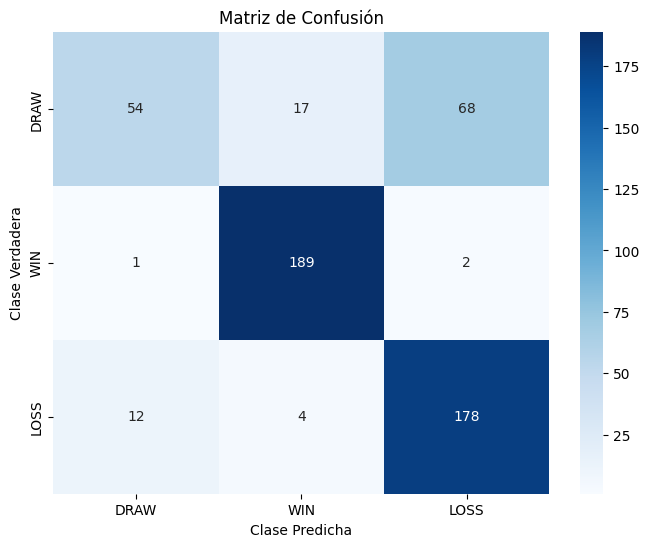

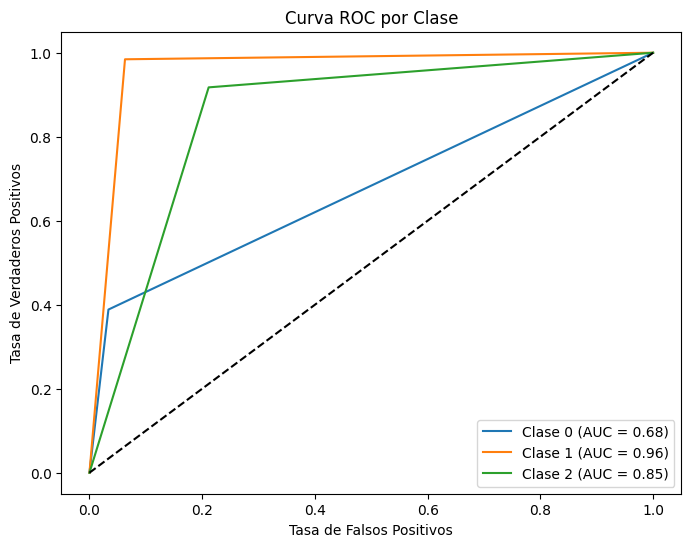

<ipython-input-23-9d23103538f1>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="Blues", label="Real", alpha=0.6)
<ipython-input-23-9d23103538f1>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="Oranges", label="Predicho", alpha=0.6)


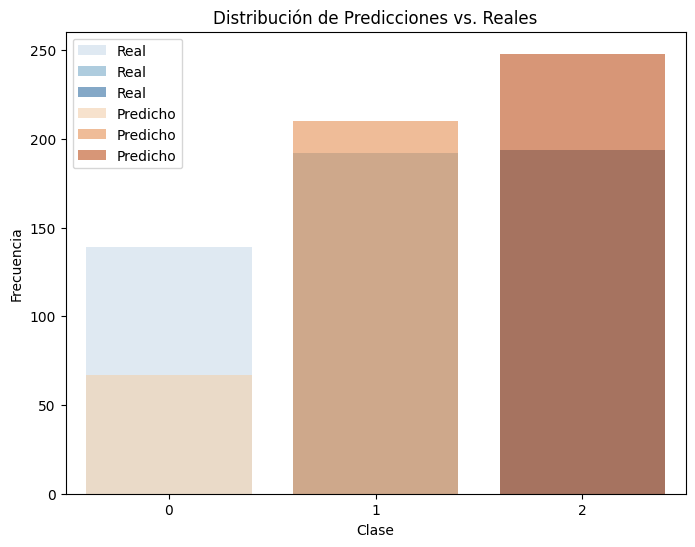

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# 1. Matriz de Confusión Visualizada
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['DRAW', 'WIN', 'LOSS'], yticklabels=['DRAW', 'WIN', 'LOSS'])
plt.title('Matriz de Confusión')
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

# 2. Curva ROC y AUC para cada clase
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_bin = lb.transform(y_pred)

fpr = {}
tpr = {}
roc_auc = {}

# Calcular la curva ROC para cada clase
for i in range(3):  # Aquí asumimos que hay 3 clases
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC por Clase')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

# 3. Distribución de Predicciones vs. Reales
plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, palette="Blues", label="Real", alpha=0.6)
sns.countplot(x=y_pred, palette="Oranges", label="Predicho", alpha=0.6)
plt.title('Distribución de Predicciones vs. Reales')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


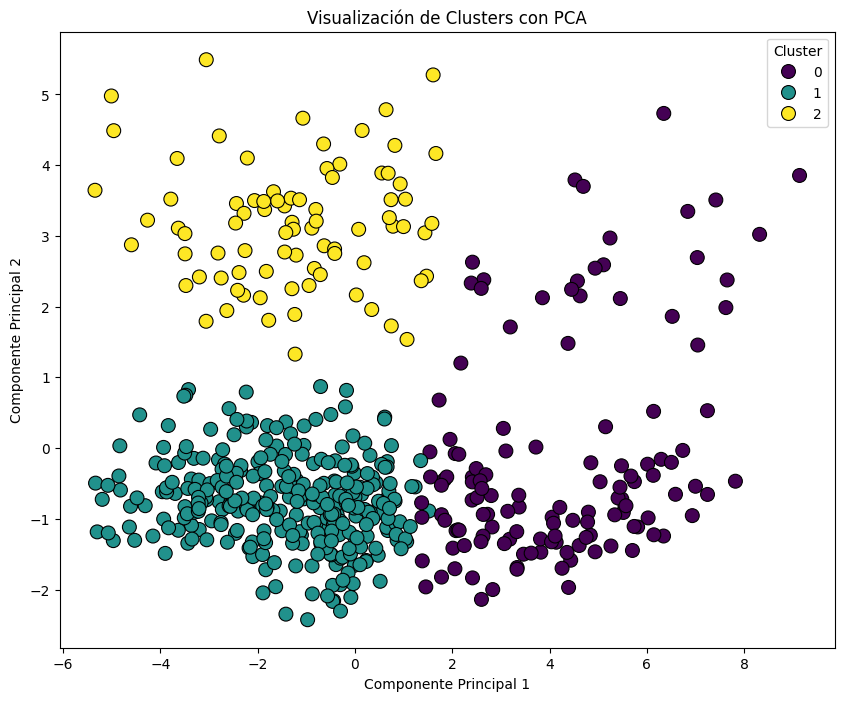

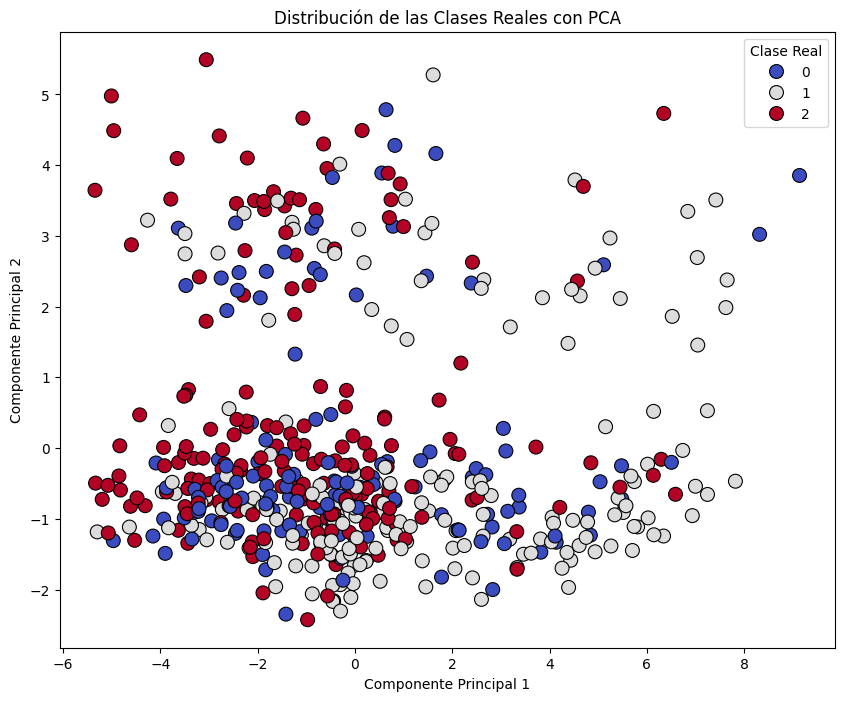

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Asegurarnos de que X_test sea lo que queremos para la visualización (si no lo hemos hecho antes)
X_test_normalized = X_normalized.loc[X_test.index]

# 1. Aplicamos KMeans Clustering a las características normalizadas
kmeans = KMeans(n_clusters=3, random_state=42)  # Asumimos que hay 3 clusters (por las 3 clases)
clusters = kmeans.fit_predict(X_test_normalized)  # Usamos X_test_normalized en lugar de X_normalized

# 2. Usamos PCA para reducir a 2 dimensiones para visualizar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_normalized)

# 3. Visualización de los Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette="viridis", s=100, marker='o', edgecolor='black')
plt.title('Visualización de Clusters con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title="Cluster")
plt.show()

# 4. Visualización de las predicciones en 2D (usando PCA también)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test, palette="coolwarm", s=100, marker='o', edgecolor='black')
plt.title('Distribución de las Clases Reales con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title="Clase Real")
plt.show()


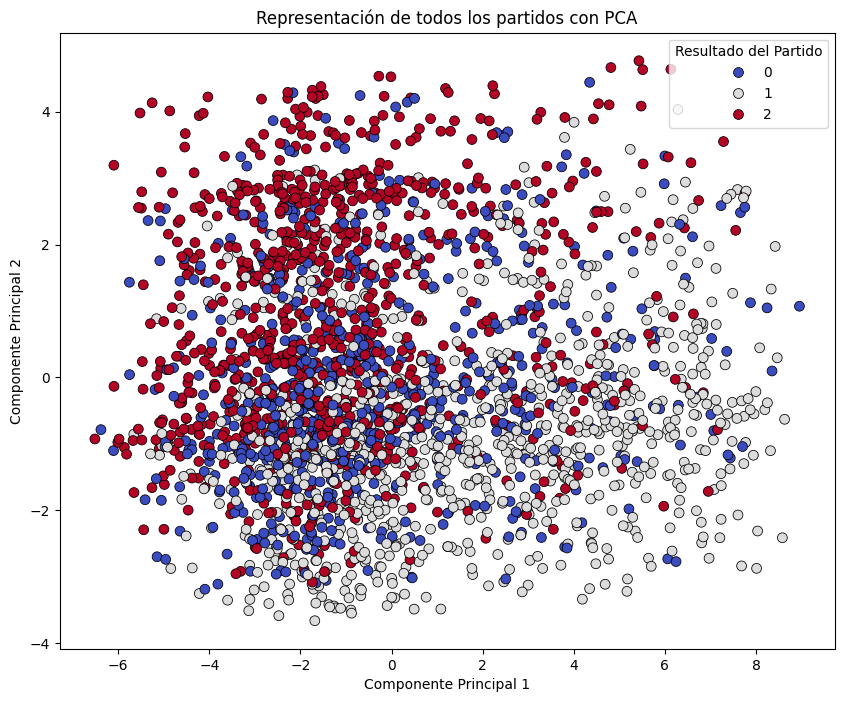

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
matches_pca = pca.fit_transform(X_normalized)  # X_normalized contiene todas las características de los partidos

# Convertir a DataFrame para facilitar el gráfico
df_pca = pd.DataFrame(matches_pca, columns=['Componente 1', 'Componente 2'])

# Asegurar que y tenga el mismo índice que X_normalized
df_pca['Resultado'] = y.values  # Convertimos y a una serie con los mismos valores pero sin índice desajustado

# Visualizar los datos de los partidos
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_pca['Componente 1'], y=df_pca['Componente 2'], hue=df_pca['Resultado'], palette='coolwarm', s=50, edgecolor='black')
plt.title('Representación de todos los partidos con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title="Resultado del Partido")
plt.show()
